### Data analysis is done using the trending videos collected data. Here, we overlooked the outliers in order to see the videos that performed remarkably well.

#### Table of contents
* Data structure
* Data cleaning
* Data wrangling
* Exploratory data analysis

#### Data structure
* Trending Video dataset contains 160 rows and 21 features
* Associated channels dataset contains 137 rows and 9 features

#### The following questions are of my interests
* Top 10 most trending videos based on their views counts, likes counts and comment counts?
* Relationship between viewers engagement and video duration or number of tags used in the video?
* Finding out the optimal video length for a video to be successful
* The most common tags that has been used in these trending videos
* Time series analysis: To find out the best time and day to upload the videos
* Whether caption availability has any impact on the viewers engagement?
* Which Audio language has the highest viewer count? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import isodate
from scipy import stats
from wordcloud import WordCloud

In [2]:
df_video = pd.read_csv('D:\Project_DA\Youtube Api\TrendingVideo_YTdata.csv', index_col = 0)
df_channels = pd.read_csv('D:\Project_DA\Youtube Api\ChannelInfo_TrendingVideo.csv', index_col = 0)

# Data Cleaning/Wrangling

In [3]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 0 to 159
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   video_id              160 non-null    object 
 1   publishedAt           160 non-null    object 
 2   channelId             160 non-null    object 
 3   title                 160 non-null    object 
 4   thumbnails            160 non-null    object 
 5   channelTitle          160 non-null    object 
 6   tags                  160 non-null    object 
 7   defaultAudioLanguage  132 non-null    object 
 8   duration              160 non-null    object 
 9   dimension             160 non-null    object 
 10  definition            160 non-null    object 
 11  caption               160 non-null    bool   
 12  licensedContent       160 non-null    bool   
 13  contentRating         160 non-null    object 
 14  projection            160 non-null    object 
 15  madeForKids           160 no

In [4]:
df_video.drop_duplicates(inplace = True)

In [5]:
#changed the data type of publishedAt column to data and time 
df_video['publishedAt'] = pd.to_datetime(df_video['publishedAt'])

In [6]:
#parse the duration into a proper time format
def parse_videoDuration(duration_str):
    duration = isodate.parse_duration(duration_str)
    return duration.total_seconds()


In [7]:
df_video['duration_in_seconds'] = df_video['duration'].apply(parse_videoDuration)

In [8]:
df_video['duration_in_minutes'] = df_video['duration_in_seconds']/ 60

In [9]:
import ast

# Convert string representation of lists into actual lists
df_video['tags'] = df_video['tags'].apply(ast.literal_eval)

In [10]:
#Compute the length of each element in the Series/Index.
df_video['number_of_tags']=df_video.tags.str.len()

In [11]:
#created a binary column for caption availability
df_video['has_caption']= df_video['caption'].apply(lambda x: 1 if x else 0)

# Top 10 most trending video

In [12]:
Top_videos =  df_video[['title', 'viewCount', 'likeCount', 'commentCount']]
Top_videos.sort_values(by=['viewCount', 'likeCount', 'commentCount'], ascending = False, inplace = True)

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_7912\1794500193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_videos.sort_values(by=['viewCount', 'likeCount', 'commentCount'], ascending = False, inplace = True)


In [13]:
Top_10_videos= Top_videos.head(10)

In [14]:
#taking only five words from each title to display in the chart 
Top_10_videos['Video_title'] = Top_10_videos['title'].str.split(' ').str[0:5]


C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_7912\212925415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_10_videos['Video_title'] = Top_10_videos['title'].str.split(' ').str[0:5]


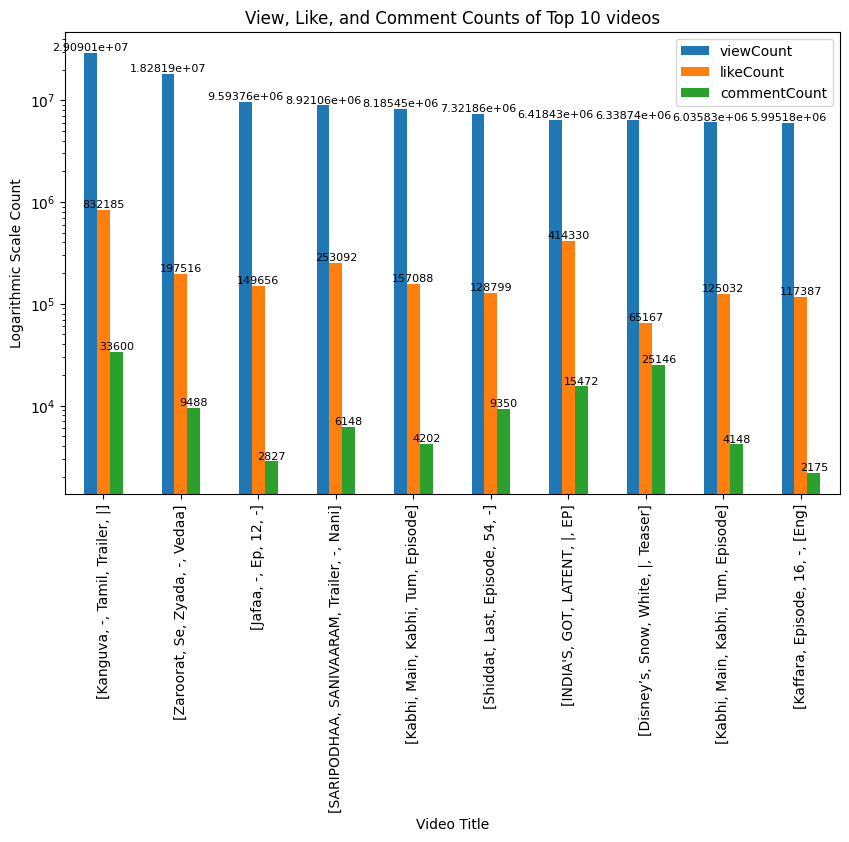

In [15]:
#plotting top 10 most trending videos along with their viewcount, likecount and commentcount
ax=Top_10_videos.plot(x = 'Video_title', kind= 'bar', stacked = False, logy = True, figsize = (10,6))
# Adding values on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8)
    
plt.ylabel('Logarithmic Scale Count')
plt.title('View, Like, and Comment Counts of Top 10 videos')
plt.xlabel('Video Title')
plt.xticks(rotation=90)

plt.show()

# Correlation analysis





#### For exceptional cases we are keeping the outliers

In [16]:
#spearman method is robust to the outliers present in the data 
res = df_video[['viewCount','likeCount', 'commentCount', 'duration_in_minutes', 'number_of_tags']].corr(method = 'spearman')

In [17]:
res

,viewCount,likeCount,commentCount,duration_in_minutes,number_of_tags
viewCount,1.000000,0.844647,0.641216,0.034719,0.197185
likeCount,0.844647,1.000000,0.844856,0.084613,0.078016
commentCount,0.641216,0.844856,1.000000,0.218718,-0.082123
duration_in_minutes,0.034719,0.084613,0.218718,1.000000,-0.001226
number_of_tags,0.197185,0.078016,-0.082123,-0.001226,1.000000


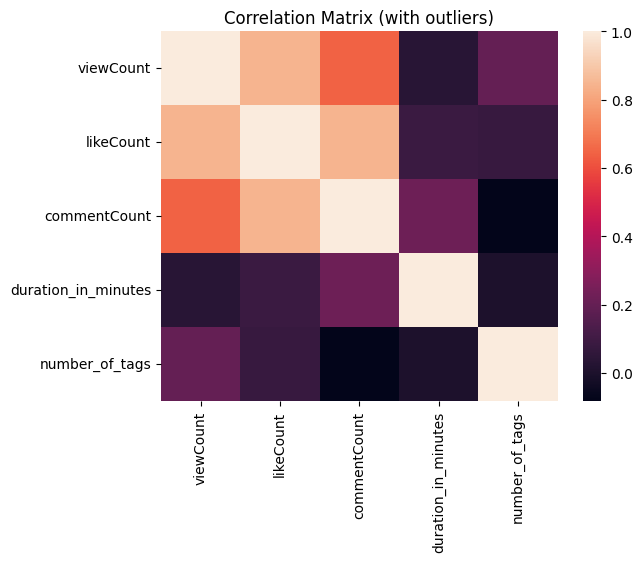

In [18]:
#heatmap
sns.heatmap(res)
plt.title('Correlation Matrix (with outliers)')
plt.show()

**The relationship between viewcount and likeCount is obvious because the higher the view more will be the like or comments**
**Other weak correlation may be because of outliers or the relationship between these variables might not be linear**

#### Regression analysis

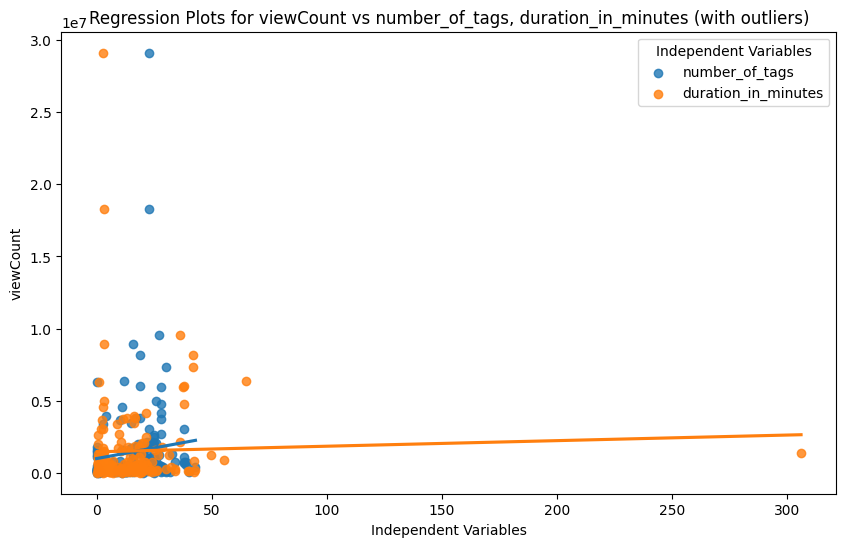

In [19]:
#Define the independent variables (x-axis) and dependent variable (y-axis)
x_cols = ['number_of_tags', 'duration_in_minutes']
y_col = 'viewCount'

# Plotting
plt.figure(figsize=(10, 6))

for x_col in x_cols:
    sns.regplot(x=x_col, y=y_col, data=df_video, label=x_col, ci=None)

plt.legend(title="Independent Variables")
plt.xlabel("Independent Variables")
plt.ylabel(y_col)
plt.title(f'Regression Plots for {y_col} vs {", ".join(x_cols)} (with outliers)')
plt.show()

#### Duration vs Engagement


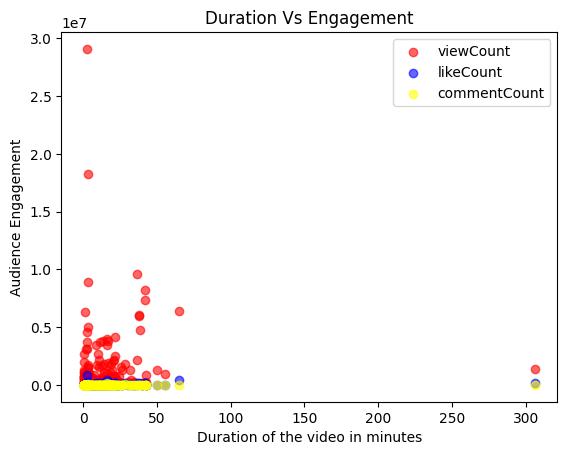

In [20]:
plt.scatter(df_video['duration_in_minutes'], df_video['viewCount'], c= 'red', alpha = 0.6, label = 'viewCount')
plt.scatter(df_video['duration_in_minutes'], df_video['likeCount'], c= 'blue', alpha = 0.6, label = 'likeCount')
plt.scatter(df_video['duration_in_minutes'], df_video['commentCount'], c= 'yellow', alpha= 0.6, label = 'commentCount')
plt.xlabel('Duration of the video in minutes')
plt.ylabel('Audience Engagement')
plt.title('Duration Vs Engagement')
plt.legend()
plt.show()

### Optimal Video length

In [21]:
# visualising time interval vs engagement
bins = [0, 2, 5, 10, 20, df_video['duration_in_minutes'].max()]

# Defined the labels for the bins
labels = ['0-2 minutes', '2-5 minutes', '5-10 minutes', '10-20 minutes', '20+ minutes']

# Created a new column with the binned duration
df_video['duration_interval'] = pd.cut(df_video['duration_in_minutes'], bins=bins, labels=labels, right=False)

In [22]:
time_int = df_video.groupby('duration_interval').agg({'viewCount': 'mean', 'likeCount': 'mean', 'commentCount': 'mean'}).reset_index()

C:\Users\NAYANIKA\AppData\Local\Temp\ipykernel_7912\1944475405.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_int = df_video.groupby('duration_interval').agg({'viewCount': 'mean', 'likeCount': 'mean', 'commentCount': 'mean'}).reset_index()


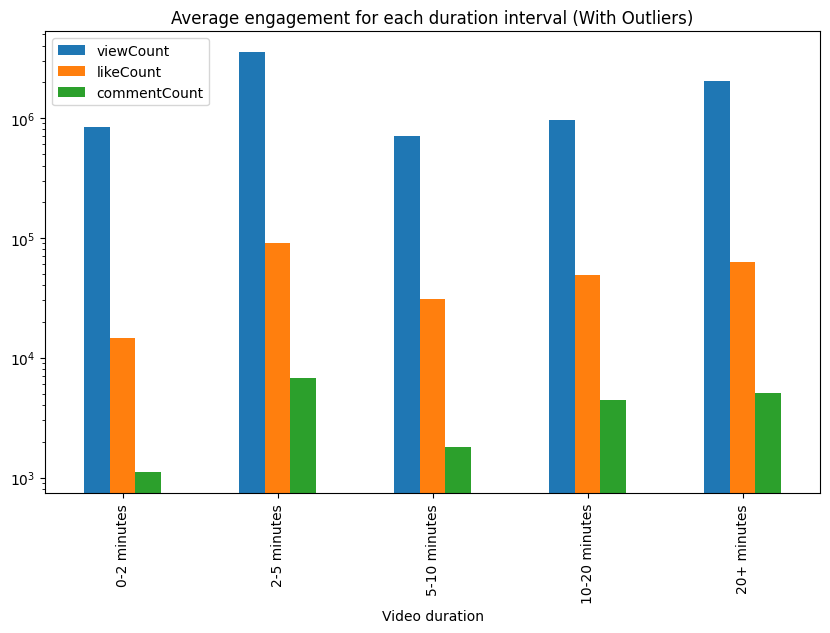

In [23]:
time_int.plot(x='duration_interval', kind = 'bar', stacked= False, logy= True, figsize = (10,6))
plt.xlabel('Video duration')
plt.title('Average engagement for each duration interval (With Outliers)')
plt.show()

**We can see that videos with the duration of 2-5 minutes has the highest viewer engagement**

#### Number of Tags Vs Engagement

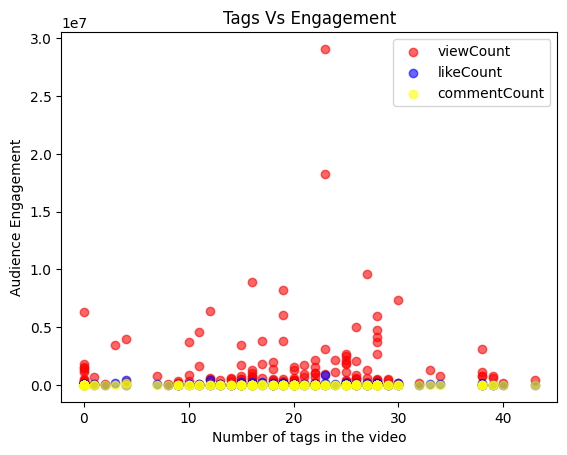

In [24]:
plt.scatter(df_video['number_of_tags'], df_video['viewCount'], c= 'red', alpha = 0.6, label = 'viewCount')
plt.scatter(df_video['number_of_tags'], df_video['likeCount'], c= 'blue', alpha = 0.6, label = 'likeCount')
plt.scatter(df_video['number_of_tags'], df_video['commentCount'], c= 'yellow', alpha= 0.6, label = 'commentCount')
plt.xlabel('Number of tags in the video')
plt.ylabel('Audience Engagement')
plt.title('Tags Vs Engagement')
plt.legend()
plt.show()

### Most common tags

In [25]:
from collections import Counter
#flatten the column tags
all_tags = [tag for sublist in df_video['tags'] for tag in sublist]

#frequency of each tag
all_tag_count = Counter(all_tags)

tag_dict = dict(all_tag_count)

tag_df = pd.DataFrame(list(tag_dict.items()), columns=['Tag', 'Frequency'])
#tag_df.sort_values(by='Frequency', ascending = False).head(50)

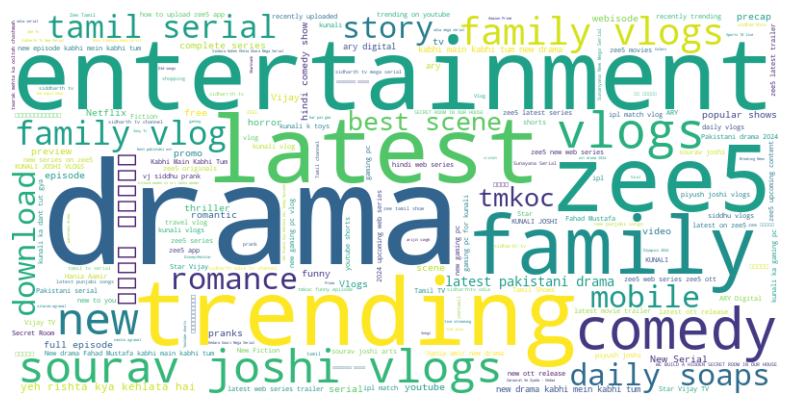

In [26]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_dict)
# Step 5: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Most frequent tags in trending videos')
plt.show()

**The bigger the size of the word, higher the number of videos where this word has been used**

### Time series Analysis

In [27]:
#extract the date components
df_video['hour'] = df_video['publishedAt'].dt.hour 
df_video['day_of_week']= df_video['publishedAt'].dt.dayofweek
df_video['month']= df_video['publishedAt'].dt.month

# Group by the time components and calculate averages
hourly_avg= df_video.groupby('hour')['viewCount'].mean().reset_index()
daily_avg = df_video.groupby('day_of_week')['viewCount'].mean().reset_index()
monthly_avg = df_video.groupby('month')['viewCount'].mean().reset_index()


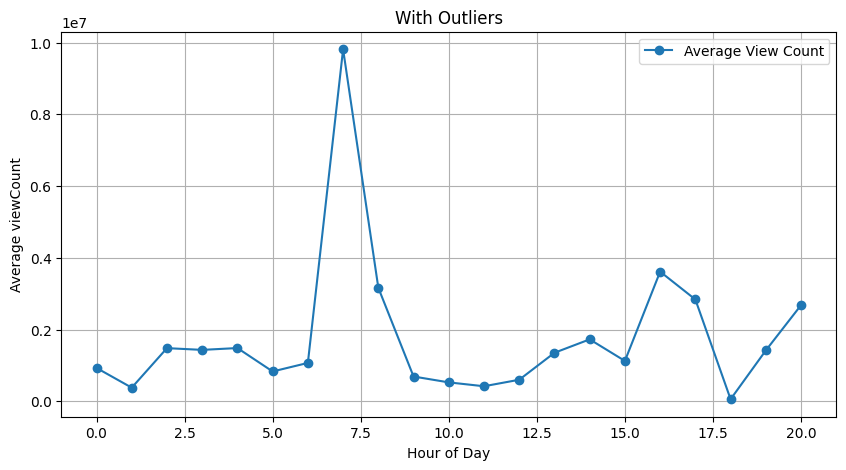

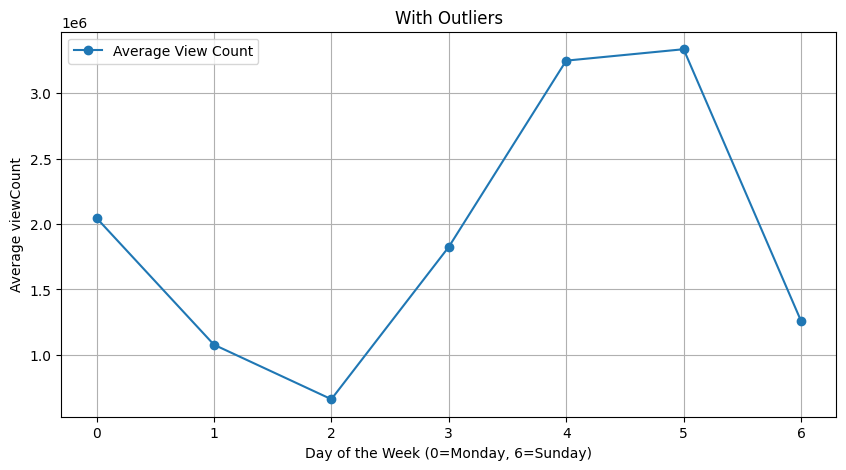

In [28]:
# Plot for hour of day
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg['viewCount'], label='Average View Count', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average viewCount')
plt.title('With Outliers')
plt.legend()
plt.grid(True)
plt.show()

# Plot for day of the week
plt.figure(figsize=(10, 5))
plt.plot(daily_avg.index, daily_avg['viewCount'], label='Average View Count', marker='o')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average viewCount')
plt.title('With Outliers')
plt.legend()
plt.grid(True)
plt.show()


### Caption Availability and Engagement 

In [29]:
caption_stats = df_video.groupby('has_caption').agg({'viewCount':'mean', 'likeCount':'mean', 'commentCount':'mean'}).reset_index()


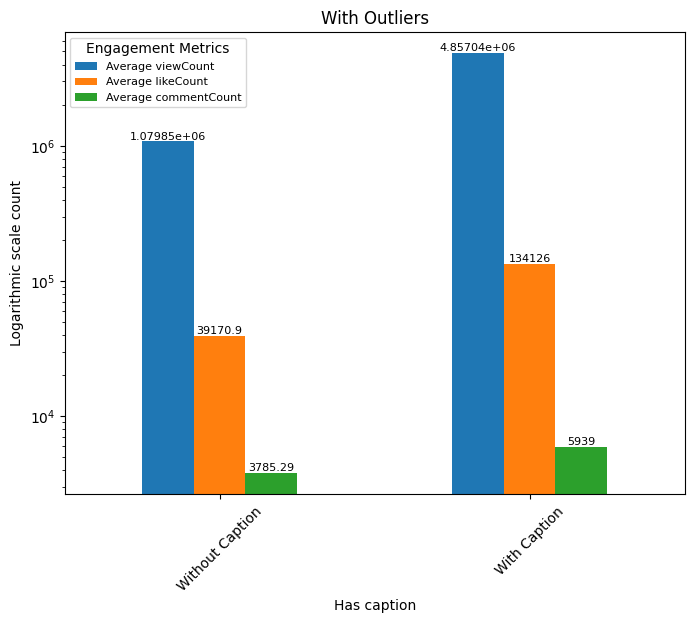

In [30]:
ax= caption_stats.plot(x = 'has_caption', kind = 'bar', logy= True, figsize = (8,6), legend = False)
ax.legend(['Average viewCount', 'Average likeCount', 'Average commentCount'], title= "Engagement Metrics", fontsize= 8)
ax.set_xticks([0,1])
ax.set_xticklabels(['Without Caption', 'With Caption'], rotation = 45)

for container in ax.containers:
    plt.bar_label(container, label_type='edge', fontsize=8)
plt.ylabel('Logarithmic scale count')
plt.xlabel('Has caption')
plt.title('With Outliers')
plt.show()

**Videos having caption has more success rate**

#### Audience Language Analysis

In [31]:
df_video.defaultAudioLanguage.unique()

array(['ta', 'te', 'en', 'en-IN', nan, 'gu', 'ml', 'hi', 'en-US', 'kn',
       'zxx', 'en-GB', 'pa', 'or', 'bh'], dtype=object)

In [32]:
df_lang= df_video.dropna()

In [33]:
df_lang_analysis= df_lang.groupby('defaultAudioLanguage').agg({'viewCount':'mean', 'likeCount':'mean', 'commentCount':'mean'}).reset_index()


en - English,
en-IN - English (India),
nan - This usually indicates that the audio language is not available or not set.,
gu - Gujarati,
ml - Malayalam,
hi - Hindi,
en-US - English (United States),
kn - Kannada,
zxx - No linguistic content (e.g., instrumental music, sound effects),
en-GB - English (United Kingdom),
pa - Punjabi,
or - Odia,
bh - Bhojpuri

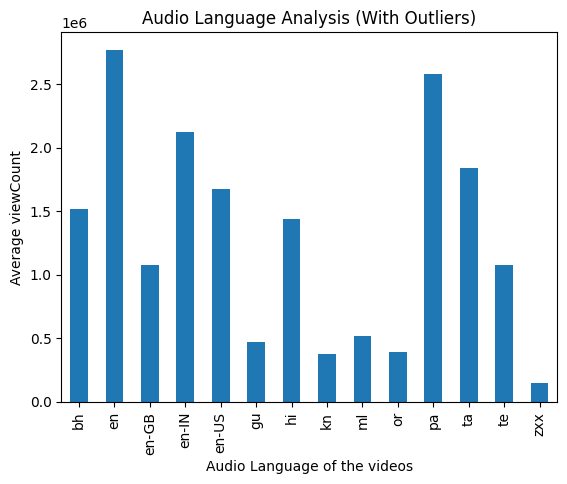

In [34]:
df_lang_analysis.plot(x='defaultAudioLanguage', y='viewCount', kind = 'bar', legend= False)
plt.xlabel('Audio Language of the videos')
plt.ylabel('Average viewCount')
plt.title('Audio Language Analysis (With Outliers)')
plt.show()

**The videos with the audio language in english has the highest view, probably because India has diverse languages and english is a language that is understand by most of us**